# Data Exploration & Preprocessing

**Obiettivo**: Caricare, esplorare e preprocessare il dataset di immagini satellitari.

**Dataset**:
- `cloudy/` - 1,500 immagini (256x256)
- `desert/` - 1,131 immagini (256x256)
- `green_area/` - 1,500 immagini (64x64)
- `water/` - 1,500 immagini (64x64)

**Task**:
1. Caricare sample da ogni categoria
2. Resize tutte a 64x64
3. Visualizzare grid di esempi
4. Analisi distribuzioni RGB (istogrammi)
5. Statistiche per categoria (media, std per canale)
6. Analisi nello spazio HSV

## 1. Imports

In [10]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print("Imports completed successfully")

Imports completed successfully


## 2. Configuration

In [6]:
# Paths
DATA_DIR = Path('../data')
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']

# Target image size for preprocessing
TARGET_SIZE = (64, 64)

# Number of samples to load per category for exploration
N_SAMPLES = 50

# Color mapping for visualization
CATEGORY_COLORS = {
    'cloudy': 'blue',
    'green_area': 'green',
    'water': 'cyan',
    'desert': 'orange'
}

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Target size: {TARGET_SIZE}")
print(f"Categories: {CATEGORIES}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
Target size: (64, 64)
Categories: ['cloudy', 'desert', 'green_area', 'water']


## 3. Load Sample Images

In [8]:
def load_images_from_category(category, n_samples=N_SAMPLES, target_size=TARGET_SIZE):
    """
    Load n_samples random images from a category and resize them.
    
    Args:
        category: category name (cloudy, desert, green_area, water)
        n_samples: number of images to load
        target_size: tuple (width, height) for resizing
    
    Returns:
        list of numpy arrays (RGB images)
    """
    category_path = DATA_DIR / category
    image_files = list(category_path.glob('*.jpg'))
    
    print(f"Found {len(image_files)} images in {category}/")
    
    # Sample random images
    sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
    
    images = []
    for img_path in sampled_files:
        # Load with PIL and convert to RGB
        img = Image.open(img_path).convert('RGB')
        # Resize to target size
        img_resized = img.resize(target_size, Image.LANCZOS)
        # Convert to numpy array
        img_array = np.array(img_resized)
        images.append(img_array)
    
    return images

# Load samples from all categories
data = {}
for category in CATEGORIES:
    print(f"\nLoading {category}...")
    data[category] = load_images_from_category(category)
    print(f"Loaded {len(data[category])} images from {category}")

print("\n" + "="*50)
print(f"Total images loaded: {sum(len(imgs) for imgs in data.values())}")
print(f"Shape of resized images: {data[CATEGORIES[0]][0].shape}")


Loading cloudy...
Found 1500 images in cloudy/
Loaded 50 images from cloudy

Loading desert...
Found 1131 images in desert/
Loaded 50 images from desert

Loading green_area...
Found 1500 images in green_area/
Loaded 50 images from green_area

Loading water...
Found 1500 images in water/
Loaded 50 images from water

Total images loaded: 200
Shape of resized images: (64, 64, 3)


## 4. Visualize Grid of Examples

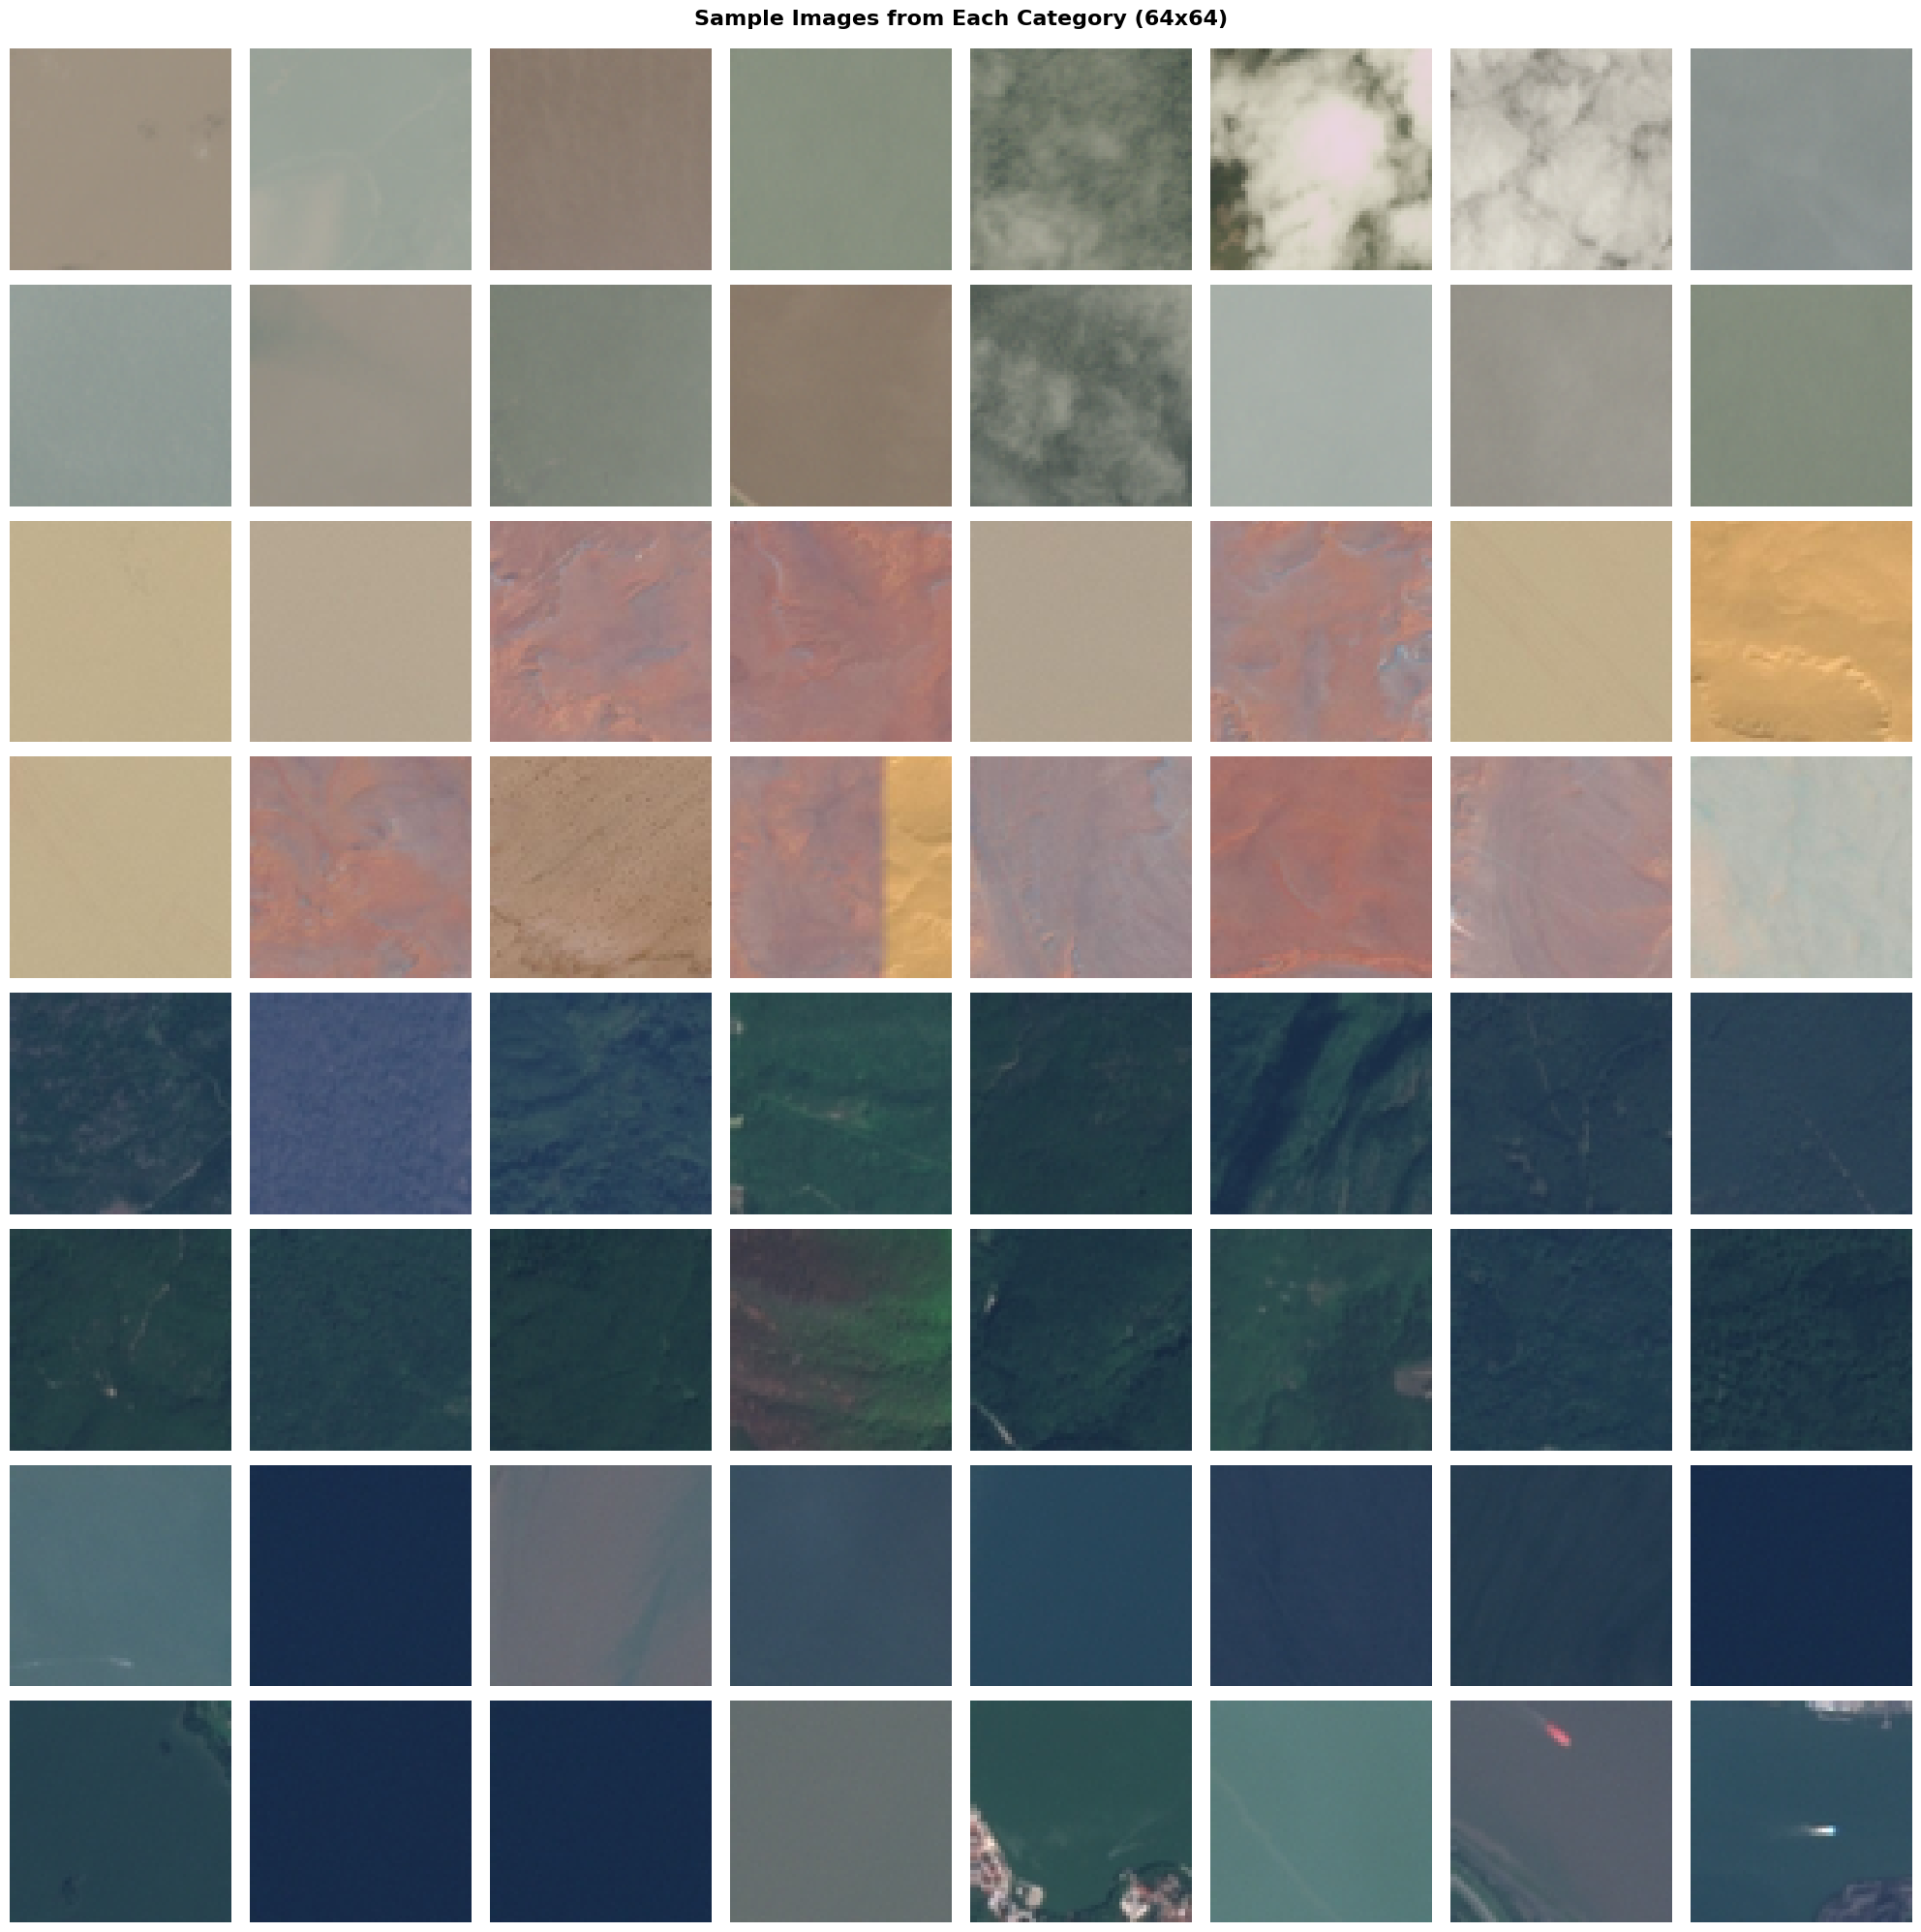

In [11]:
def plot_image_grid(data, n_cols=8, n_rows_per_category=2):
    """
    Plot a grid showing sample images from each category.
    """
    n_categories = len(data)
    fig, axes = plt.subplots(n_categories * n_rows_per_category, n_cols, 
                             figsize=(20, n_categories * n_rows_per_category * 2.5))
    
    for cat_idx, (category, images) in enumerate(data.items()):
        for row in range(n_rows_per_category):
            for col in range(n_cols):
                ax_idx = cat_idx * n_rows_per_category + row
                ax = axes[ax_idx, col]
                
                img_idx = row * n_cols + col
                if img_idx < len(images):
                    ax.imshow(images[img_idx])
                    ax.axis('off')
                    
                    # Add category label only on first image of each category
                    if col == 0 and row == 0:
                        ax.set_ylabel(category.replace('_', ' ').title(), 
                                     fontsize=12, fontweight='bold')
                else:
                    ax.axis('off')
    
    plt.suptitle('Sample Images from Each Category (64x64)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

plot_image_grid(data)

## 5. RGB Color Distribution Analysis

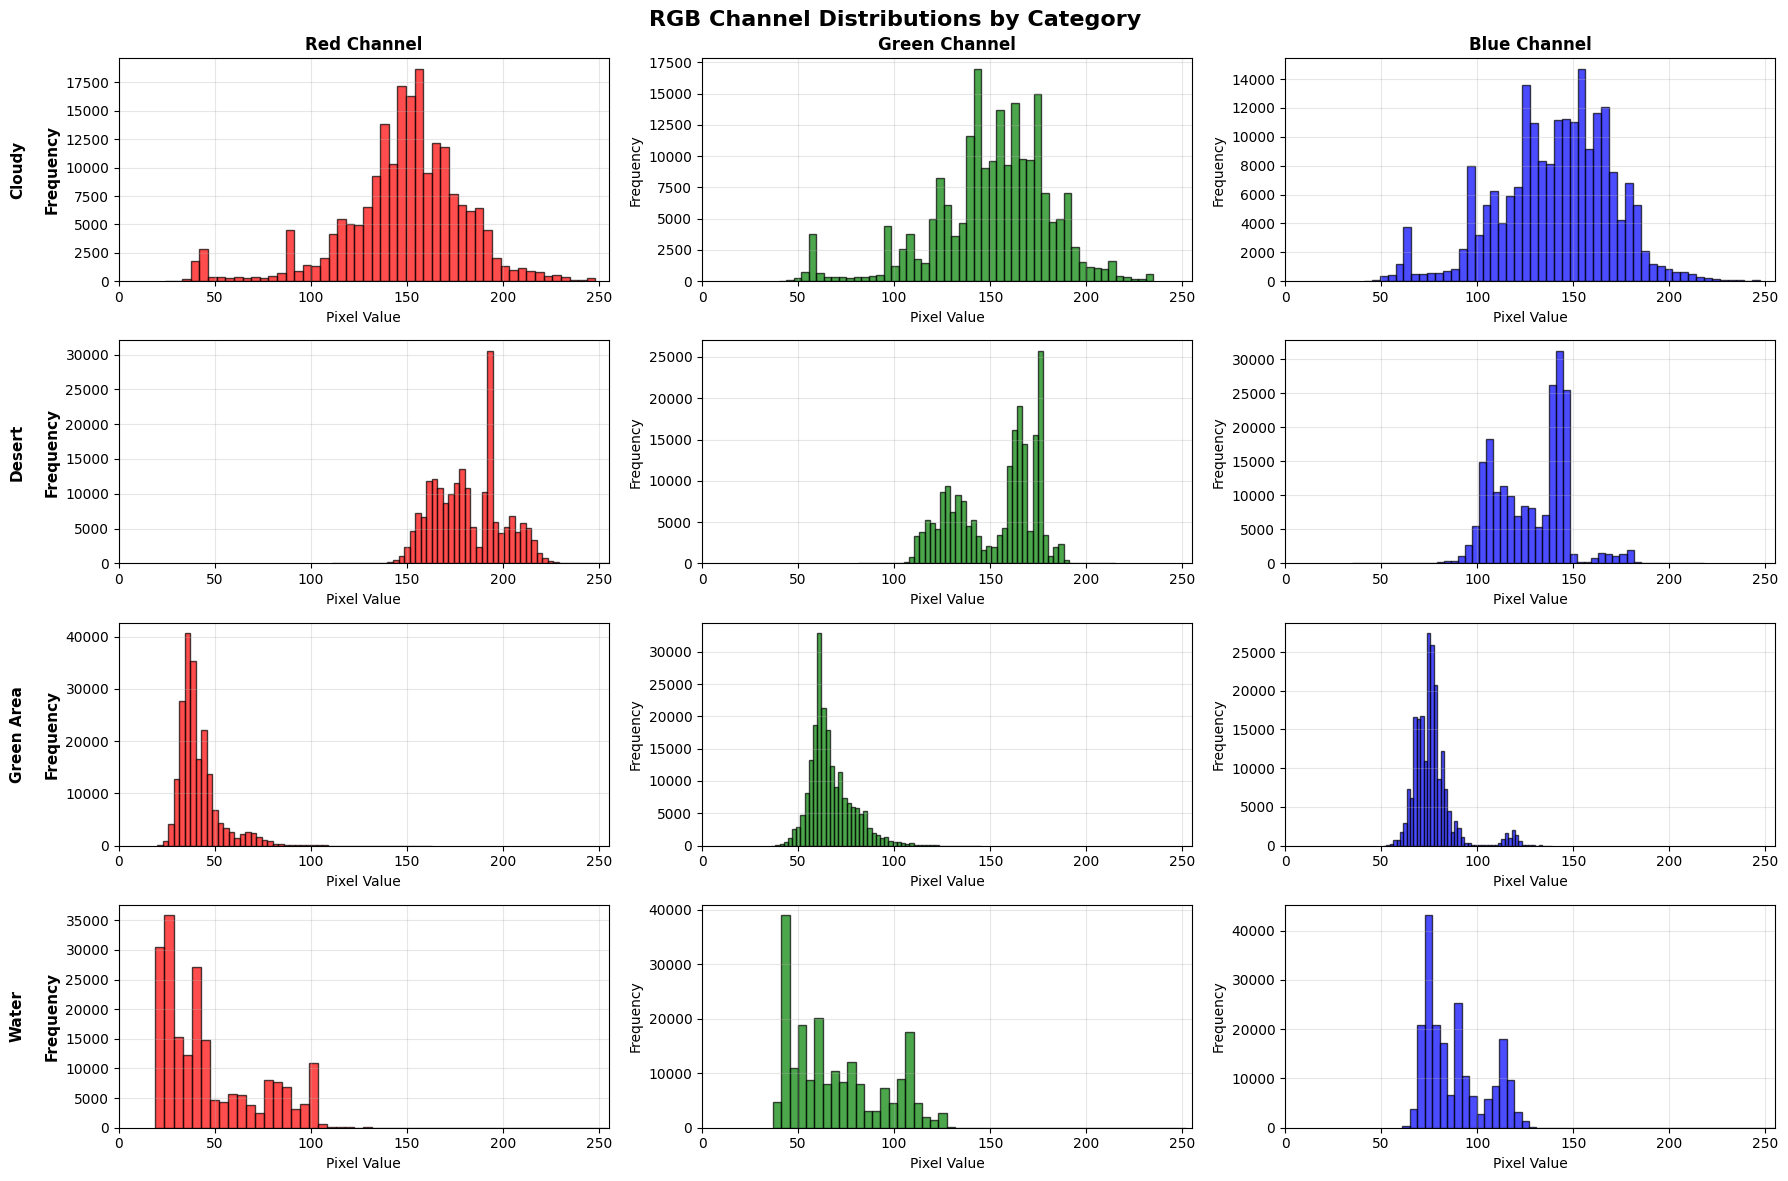

In [12]:
def plot_rgb_histograms(data):
    """
    Plot RGB histograms for each category.
    """
    fig, axes = plt.subplots(len(CATEGORIES), 3, figsize=(18, len(CATEGORIES) * 3))
    
    channel_names = ['Red', 'Green', 'Blue']
    channel_colors = ['red', 'green', 'blue']
    
    for cat_idx, category in enumerate(CATEGORIES):
        images = np.array(data[category])
        
        for channel_idx in range(3):
            ax = axes[cat_idx, channel_idx]
            
            # Extract channel data
            channel_data = images[:, :, :, channel_idx].flatten()
            
            # Plot histogram
            ax.hist(channel_data, bins=50, color=channel_colors[channel_idx], 
                   alpha=0.7, edgecolor='black')
            ax.set_xlabel('Pixel Value')
            ax.set_ylabel('Frequency')
            ax.set_xlim([0, 255])
            ax.grid(True, alpha=0.3)
            
            # Add title
            if cat_idx == 0:
                ax.set_title(f'{channel_names[channel_idx]} Channel', 
                           fontsize=12, fontweight='bold')
            
            # Add category label on left
            if channel_idx == 0:
                ax.set_ylabel(f'{category.replace("_", " ").title()}\n\nFrequency', 
                            fontsize=11, fontweight='bold')
    
    plt.suptitle('RGB Channel Distributions by Category', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_rgb_histograms(data)

## 6. Statistical Analysis (Mean & Std per Channel)

In [14]:
def compute_statistics(data):
    """
    Compute mean and std for each RGB channel per category.
    """
    stats = {}
    
    for category in CATEGORIES:
        images = np.array(data[category])
        
        # Compute mean and std per channel
        mean_r = np.mean(images[:, :, :, 0])
        mean_g = np.mean(images[:, :, :, 1])
        mean_b = np.mean(images[:, :, :, 2])
        
        std_r = np.std(images[:, :, :, 0])
        std_g = np.std(images[:, :, :, 1])
        std_b = np.std(images[:, :, :, 2])
        
        stats[category] = {
            'mean': [mean_r, mean_g, mean_b],
            'std': [std_r, std_g, std_b]
        }
    
    return stats

# Compute and display statistics
stats = compute_statistics(data)

print("RGB Statistics by Category")
print("="*70)
for category in CATEGORIES:
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean (R, G, B): {stats[category]['mean'][0]:.2f}, "
          f"{stats[category]['mean'][1]:.2f}, {stats[category]['mean'][2]:.2f}")
    print(f"  Std  (R, G, B): {stats[category]['std'][0]:.2f}, "
          f"{stats[category]['std'][1]:.2f}, {stats[category]['std'][2]:.2f}")

RGB Statistics by Category

Cloudy:
  Mean (R, G, B): 148.26, 151.01, 140.62
  Std  (R, G, B): 32.71, 30.74, 30.11

Desert:
  Mean (R, G, B): 181.87, 153.44, 128.46
  Std  (R, G, B): 17.93, 21.05, 18.99

Green Area:
  Mean (R, G, B): 41.30, 66.73, 76.47
  Std  (R, G, B): 10.29, 10.99, 10.64

Water:
  Mean (R, G, B): 47.35, 70.22, 88.47
  Std  (R, G, B): 25.50, 24.44, 16.23


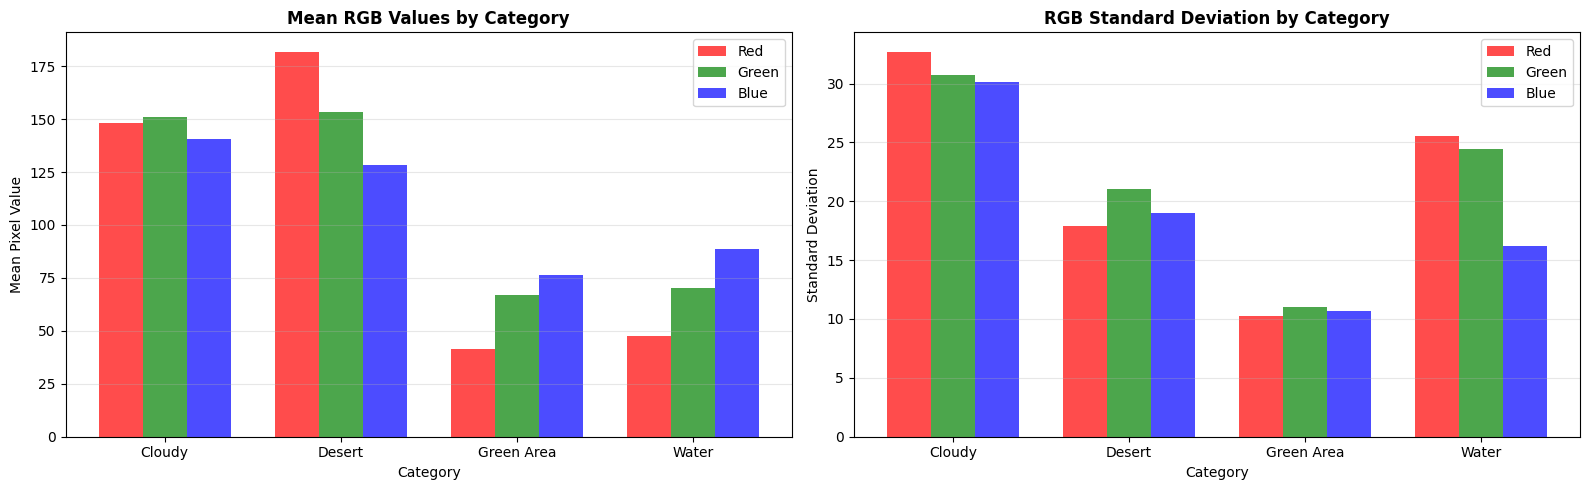

In [16]:
def plot_mean_std_comparison(stats):
    """
    Plot bar charts comparing mean and std across categories.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    categories = list(stats.keys())
    x = np.arange(len(categories))
    width = 0.25
    
    # Plot means
    ax = axes[0]
    means_r = [stats[cat]['mean'][0] for cat in categories]
    means_g = [stats[cat]['mean'][1] for cat in categories]
    means_b = [stats[cat]['mean'][2] for cat in categories]
    
    ax.bar(x - width, means_r, width, label='Red', color='red', alpha=0.7)
    ax.bar(x, means_g, width, label='Green', color='green', alpha=0.7)
    ax.bar(x + width, means_b, width, label='Blue', color='blue', alpha=0.7)
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Mean Pixel Value')
    ax.set_title('Mean RGB Values by Category', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot stds
    ax = axes[1]
    stds_r = [stats[cat]['std'][0] for cat in categories]
    stds_g = [stats[cat]['std'][1] for cat in categories]
    stds_b = [stats[cat]['std'][2] for cat in categories]
    
    ax.bar(x - width, stds_r, width, label='Red', color='red', alpha=0.7)
    ax.bar(x, stds_g, width, label='Green', color='green', alpha=0.7)
    ax.bar(x + width, stds_b, width, label='Blue', color='blue', alpha=0.7)
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Standard Deviation')
    ax.set_title('RGB Standard Deviation by Category', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_mean_std_comparison(stats)

## 7. HSV Color Space Analysis

In [17]:
def convert_to_hsv(data):
    """
    Convert RGB images to HSV color space.
    """
    hsv_data = {}
    
    for category in CATEGORIES:
        hsv_images = []
        for rgb_img in data[category]:
            # cv2.cvtColor expects uint8
            hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
            hsv_images.append(hsv_img)
        hsv_data[category] = hsv_images
    
    return hsv_data

# Convert to HSV
hsv_data = convert_to_hsv(data)
print("Converted images to HSV color space")

Converted images to HSV color space


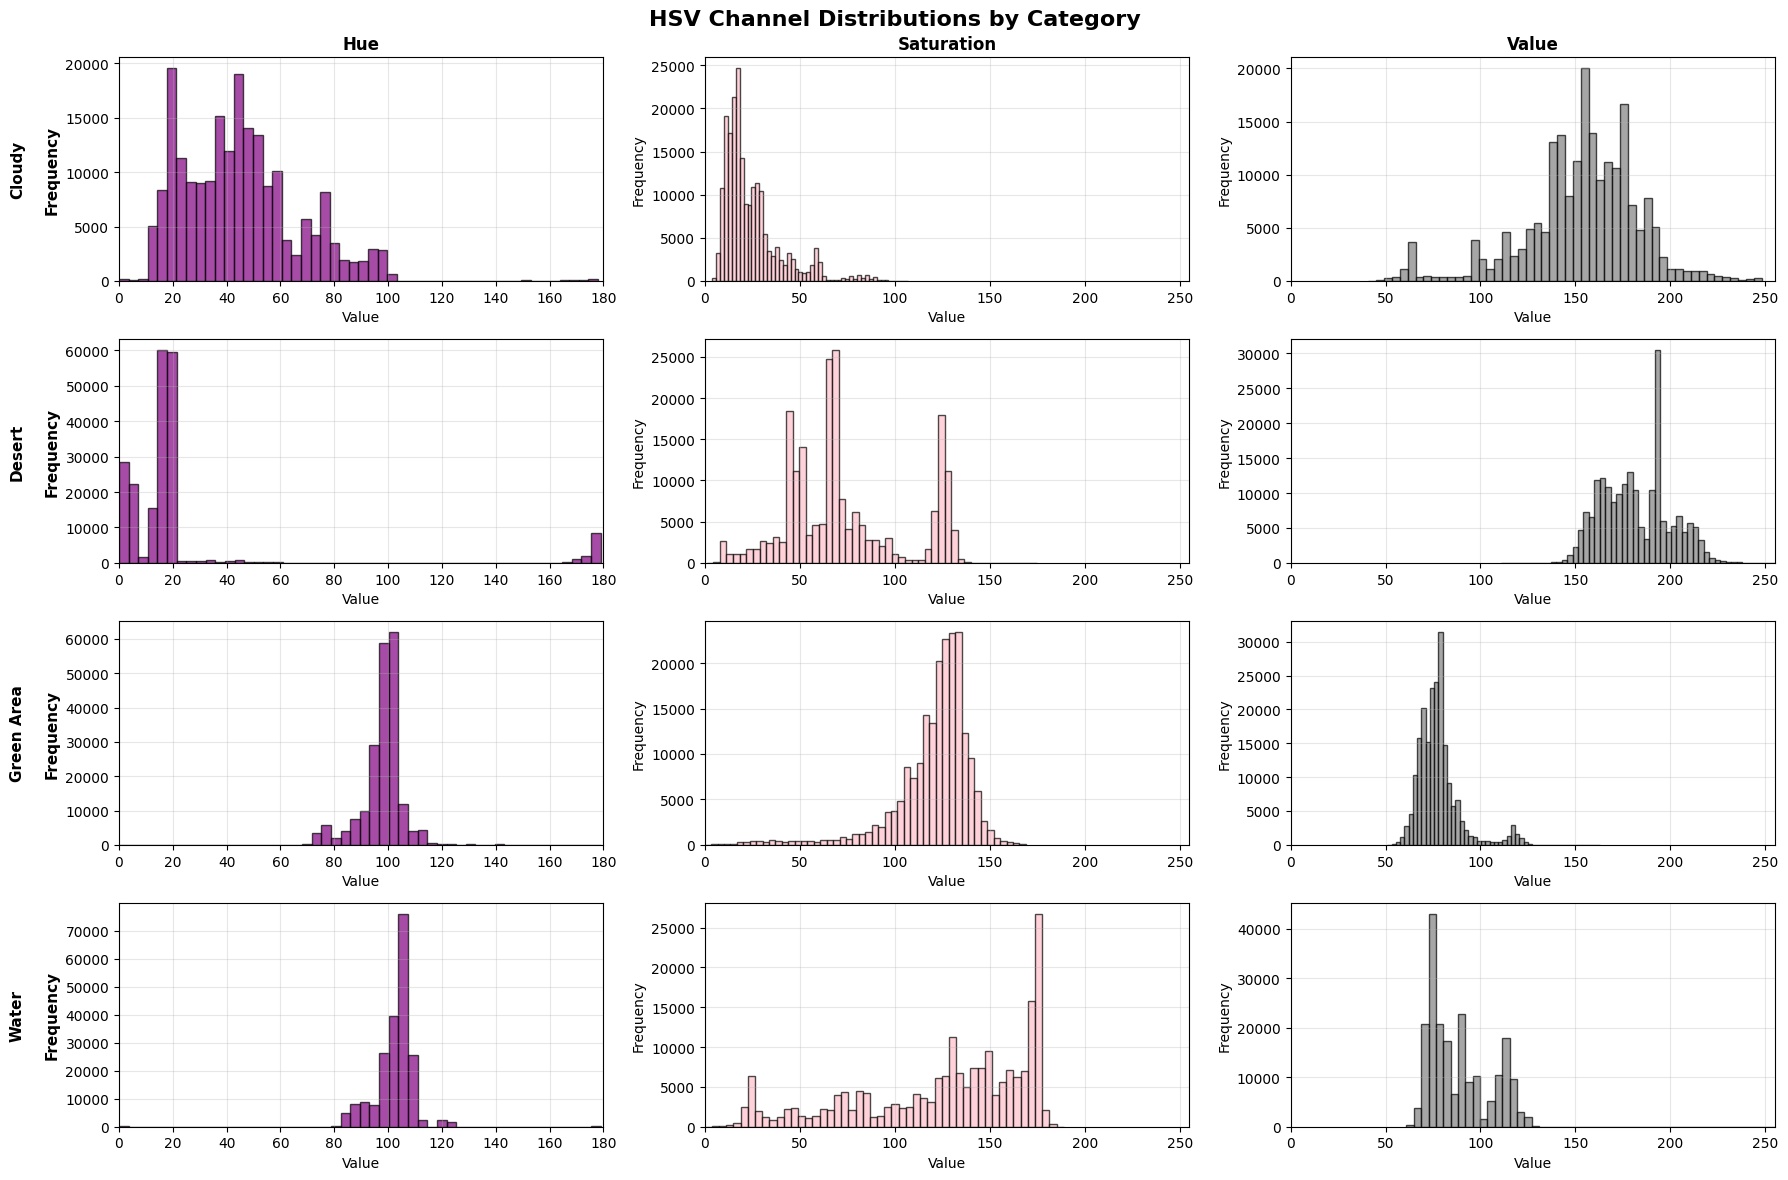

In [18]:
def plot_hsv_histograms(hsv_data):
    """
    Plot HSV histograms for each category.
    """
    fig, axes = plt.subplots(len(CATEGORIES), 3, figsize=(18, len(CATEGORIES) * 3))
    
    channel_names = ['Hue', 'Saturation', 'Value']
    channel_colors = ['purple', 'pink', 'gray']
    
    for cat_idx, category in enumerate(CATEGORIES):
        images = np.array(hsv_data[category])
        
        for channel_idx in range(3):
            ax = axes[cat_idx, channel_idx]
            
            # Extract channel data
            channel_data = images[:, :, :, channel_idx].flatten()
            
            # Plot histogram
            ax.hist(channel_data, bins=50, color=channel_colors[channel_idx], 
                   alpha=0.7, edgecolor='black')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            
            # Hue is 0-179 in OpenCV, S and V are 0-255
            if channel_idx == 0:
                ax.set_xlim([0, 180])
            else:
                ax.set_xlim([0, 255])
            
            ax.grid(True, alpha=0.3)
            
            # Add title
            if cat_idx == 0:
                ax.set_title(f'{channel_names[channel_idx]}', 
                           fontsize=12, fontweight='bold')
            
            # Add category label on left
            if channel_idx == 0:
                ax.set_ylabel(f'{category.replace("_", " ").title()}\n\nFrequency', 
                            fontsize=11, fontweight='bold')
    
    plt.suptitle('HSV Channel Distributions by Category', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_hsv_histograms(hsv_data)

In [19]:
def compute_hsv_statistics(hsv_data):
    """
    Compute mean and std for each HSV channel per category.
    """
    hsv_stats = {}
    
    for category in CATEGORIES:
        images = np.array(hsv_data[category])
        
        # Compute mean and std per channel
        mean_h = np.mean(images[:, :, :, 0])
        mean_s = np.mean(images[:, :, :, 1])
        mean_v = np.mean(images[:, :, :, 2])
        
        std_h = np.std(images[:, :, :, 0])
        std_s = np.std(images[:, :, :, 1])
        std_v = np.std(images[:, :, :, 2])
        
        hsv_stats[category] = {
            'mean': [mean_h, mean_s, mean_v],
            'std': [std_h, std_s, std_v]
        }
    
    return hsv_stats

# Compute and display HSV statistics
hsv_stats = compute_hsv_statistics(hsv_data)

print("HSV Statistics by Category")
print("="*70)
for category in CATEGORIES:
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean (H, S, V): {hsv_stats[category]['mean'][0]:.2f}, "
          f"{hsv_stats[category]['mean'][1]:.2f}, {hsv_stats[category]['mean'][2]:.2f}")
    print(f"  Std  (H, S, V): {hsv_stats[category]['std'][0]:.2f}, "
          f"{hsv_stats[category]['std'][1]:.2f}, {hsv_stats[category]['std'][2]:.2f}")

HSV Statistics by Category

Cloudy:
  Mean (H, S, V): 45.04, 24.50, 153.06
  Std  (H, S, V): 21.86, 15.16, 30.32

Desert:
  Mean (H, S, V): 23.79, 73.38, 181.93
  Std  (H, S, V): 39.05, 31.22, 17.93

Green Area:
  Mean (H, S, V): 98.02, 120.59, 77.80
  Std  (H, S, V): 8.20, 20.31, 11.35

Water:
  Mean (H, S, V): 102.72, 126.34, 88.71
  Std  (H, S, V): 7.71, 45.59, 16.53


## 8. Summary & Key Observations

In [ ]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print("\nDataset Overview:")
for category in CATEGORIES:
    total_files = len(list((DATA_DIR / category).glob('*.jpg')))
    print(f"  - {category.replace('_', ' ').title()}: {total_files} images")

print(f"\nTarget preprocessing size: {TARGET_SIZE}")
print(f"Samples loaded per category: {N_SAMPLES}")

print("\n" + "-"*70)
print("Key Observations for Filter Development:")
print("-"*70)

print("\n1. CLOUDY:")
print(f"   - RGB Mean: R={stats['cloudy']['mean'][0]:.1f}, "
      f"G={stats['cloudy']['mean'][1]:.1f}, B={stats['cloudy']['mean'][2]:.1f}")
print(f"   - HSV Mean: H={hsv_stats['cloudy']['mean'][0]:.1f}, "
      f"S={hsv_stats['cloudy']['mean'][1]:.1f}, V={hsv_stats['cloudy']['mean'][2]:.1f}")
print("   - Expected: High brightness (V), low saturation (S), balanced RGB")

print("\n2. GREEN AREA (Vegetation):")
print(f"   - RGB Mean: R={stats['green_area']['mean'][0]:.1f}, "
      f"G={stats['green_area']['mean'][1]:.1f}, B={stats['green_area']['mean'][2]:.1f}")
print(f"   - HSV Mean: H={hsv_stats['green_area']['mean'][0]:.1f}, "
      f"S={hsv_stats['green_area']['mean'][1]:.1f}, V={hsv_stats['green_area']['mean'][2]:.1f}")
print("   - Expected: Green channel > others, Hue in green range (60-90)")

print("\n3. WATER:")
print(f"   - RGB Mean: R={stats['water']['mean'][0]:.1f}, "
      f"G={stats['water']['mean'][1]:.1f}, B={stats['water']['mean'][2]:.1f}")
print(f"   - HSV Mean: H={hsv_stats['water']['mean'][0]:.1f}, "
      f"S={hsv_stats['water']['mean'][1]:.1f}, V={hsv_stats['water']['mean'][2]:.1f}")
print("   - Expected: Blue channel dominant, Hue in blue/cyan range (90-120)")

print("\n4. DESERT:")
print(f"   - RGB Mean: R={stats['desert']['mean'][0]:.1f}, "
      f"G={stats['desert']['mean'][1]:.1f}, B={stats['desert']['mean'][2]:.1f}")
print(f"   - HSV Mean: H={hsv_stats['desert']['mean'][0]:.1f}, "
      f"S={hsv_stats['desert']['mean'][1]:.1f}, V={hsv_stats['desert']['mean'][2]:.1f}")
print("   - Expected: Warm tones (R > G > B), Hue in yellow/orange range (10-30)")

print("\n" + "="*70)
print("✓ Data exploration completed successfully")
print("  Next step: Implement cloud detection filter (01_filter_clouds.ipynb)")
print("="*70)


SUMMARY

Dataset Overview:
  - Cloudy: 1500 images
  - Desert: 1131 images
  - Green Area: 1500 images
  - Water: 1500 images

Target preprocessing size: (64, 64)
Samples loaded per category: 50

----------------------------------------------------------------------
Key Observations for Filter Development:
----------------------------------------------------------------------

1. CLOUDY:
   - RGB Mean: R=148.3, G=151.0, B=140.6
   - HSV Mean: H=45.0, S=24.5, V=153.1
   - Expected: High brightness (V), low saturation (S), balanced RGB

2. GREEN AREA (Vegetation):
   - RGB Mean: R=41.3, G=66.7, B=76.5
   - HSV Mean: H=98.0, S=120.6, V=77.8
   - Expected: Green channel > others, Hue in green range (60-90)

3. WATER:
   - RGB Mean: R=47.4, G=70.2, B=88.5
   - HSV Mean: H=102.7, S=126.3, V=88.7
   - Expected: Blue channel dominant, Hue in blue/cyan range (90-120)

4. DESERT:
   - RGB Mean: R=181.9, G=153.4, B=128.5
   - HSV Mean: H=23.8, S=73.4, V=181.9
   - Expected: Warm tones (R > G > B

: 